In [ ]:
from IPython.core.display import HTML
from datascience import *

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import pandas as pd
import zipfile
import io
import math

def css_styling():
    styles = open('../notebook_styles.css', 'r').read()
    return HTML(styles)
css_styling()

In [ ]:
#Loading testing data
from client.api.notebook import Notebook 
lab08 = Notebook('lab08.ok')
_ = lab08.auth(inline=True)

# Lab 08 - Political demography

## Introductions

**What is your partner's name?**

[ANSWER HERE]

**What is your partner's favorite color?**

[ANSWER HERE]

**What is your partner's favorite hobby?**

[ANSWER HERE]

## US Census voting and registration estimates

The US Census produces tables with estimates of [voting and registration in 2016](https://www.census.gov/data/tables/time-series/demo/voting-and-registration/p20-580.html) by state and age group. The Census Bureau produces these estimates by combining its population projections with information from a large and high quality survey called the Current Population Survey (CPS). They even have a [blog post](https://www.census.gov/newsroom/blogs/random-samplings/2017/05/voting_in_america.html) that explains a little more about how the estimates are calculated.

The CPS asks people who respond to the survey whether or not they are citizens and whether or not they voted in the last election. This information can then be used to estimate the proportion of citizens who voted in the last election.

The CPS is pretty important: it is used to measure, among other things, the unemployment rate. So it is a very careful and rigorous survey. Nonetheless, most political scientists and demographers would be a little cautious about interpreting the data we're going to analyze today.

**Question - Thinking about how the data are collected, come up with two biases that you think might affect estimates of voting and citizenship from the CPS data.**

[ANSWER HERE]

## Diving in

First, we'll open up the data on voting for 2016:

In [ ]:
voting_2016 = Table.read_table('../data/us-census/electorate/census_2016_turnout_estimates.csv')
voting_2016

It will be helpful to have a list of all of the states in the dataset.

In [ ]:
all_states = np.unique(voting_2016['state'])
all_states

Let's get rid of the state 'US', which has values for the entire country.

In [ ]:
all_states = all_states[all_states != 'US']
all_states

### Numbers of people voting by state

We'll start by looking at the number of people who vote in each state.

**Question - Make a table that has the total number of people who voted in each state in 2016. Do this by filtering the `voting_2016` data down to only the age group 'Total', and also remove the state 'US' (which has national-level totals).**

In [ ]:
voting_2016_tot = ...
voting_2016_tot

**Question - Make a sideways bar plot (using `barh`) that shows the number of people who voted in each state in 2016.**   
*[HINT: you should use the `voting_2016_tot` Table. You should focus on the total vote, given when age is equal to 'Total'. And you should also remove the rows corresponding to `US`, which are the values for the whole country.]*

In [ ]:
...

A moment's reflection will reveal that it seems like the states that are biggest -- i.e., California, Texas, Florida, New York -- cast the most ballots. Let's be sure that intuition is correct:

**Question - What are the five states with the largest populations?**   
*[HINT: Use the `sort` function to print out the first few rows of the `voting_2016_tot` dataset*]

In [ ]:
...

OK, we'd like to compare states' tendency to vote, ignoring differences in the size of each state. One way to think about this is that we'd like to *control* for state size.  A simple way to do so is to look at the percent of citizens who voted in each state, rather than the number of votes.

**Question - Make the same horizontal bar plot, this time for the percent of citizens who voted (instead of the number of votes).**

In [ ]:
...

**Question - How would you describe the amount of variation in how much people vote by state? Are states pretty similar, or do some states vote much more than others?**

[ANSWER HERE]

**Question -- Which states had the highest and lowest voting rates in 2016?**

[ANSWER HERE]

## Investigating voting by age and state

To better understand voting, we'll break it down by age group.

**Question - Before we start, make a guess at about what percentage of citizens in the 18 to 24 age range voted in the 2016 election.**

[ANSWER HERE]

Now let's dive into the data. We'll start by using a helper function which will add a numeric variable for age, to make it easier to work with. We'll use this function to create a new Table, `voting_2016_byage`, that has information on voting by state and age in 2016:

In [ ]:
def prep_voting_byage_data(df):
    df = df.where('age', are.not_equal_to('Total')).where('state', are.not_equal_to('US'))
    df = df.to_df()
    df['agegp'] = df['age'].map({'18 to 24' : 18,
                                 '25 to 34' : 25,
                                 '35 to 44' : 35,
                                 '45 to 64' : 45,
                                      '65+' : 65})
    df = Table().from_df(df)
    return(df)

voting_2016_byage = prep_voting_byage_data(voting_2016)
voting_2016_byage

The plot below compares the number of citizens registered to vote (blue) and who actually voted in 2016 (gold) for New York. You can see that, in New York, the number of votes cast and the number of registered voters are both strongly related to age:

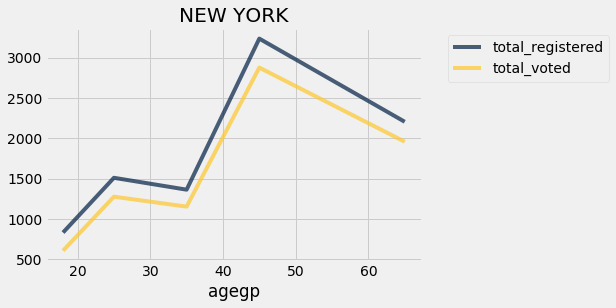

**Question - Make a plot analagous to the one above, but for California. Does California's gap between registration and voting look similar, smaller, or bigger than New York's?**

In [ ]:
...

The plot you made above doesn't answer an important question: do people who are older vote more, or are there just more old people? Or, is it some combination of both of those factors? We'd like to find a way to study the rate at which people in each state vote by age without getting distracted by the underlying population age distribution in the state.

One way to control for age structure is to calculate the proportion of eligible people who are registered and who vote, rather than looking at totals. This will produce figures that are more comparable between New York and California.

The plot below compares the percentage of citizens that is registered to vote (blue) and that actually voted in 2016 (gold) for New York. This plot makes it clearer that it's not that there are more old people in New York -- it's that old people vote at a much higher rate than young people.

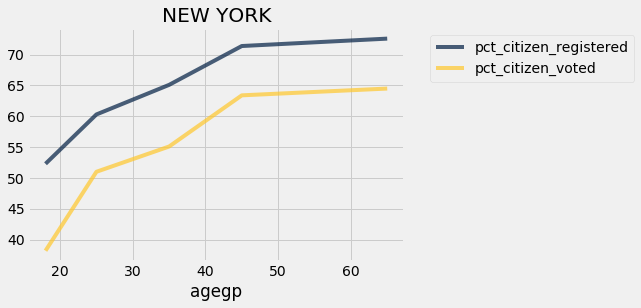

**Question - Make a plot analagous to the one above, but for California. Does California's gap between registration and voting look similar, smaller, or bigger than New York's?**

In [ ]:
...

**Question - Based on the plots for California and New York, how close or far off was your guess at  what percentage of citizens in the 18 to 24 age range voted in the 2016 election?**

[ANSWER HERE]

It seems that in New York and California, young people vote at much lower rates than old people.  We might wonder: does this vary much by state?

**Question - In which state did the highest percentage of 18 to 24 year old citizens (who are in `agegp` 18) vote? The lowest?**

In [ ]:
...

## Standarize to US citizen popn by age

You just compared voting rates for the youngest age group across states. That's useful for understanding the voting behavior or young people, but what if you wanted to compare voting rates in aggregate across states? You might worry that, since (1) voting is very strongly related to age; and (2) states have different age distributions, if you just compare raw voting rates across states, you might be picking up differences in age structure rather than differences in voting *per se*.

One way to try to get around this challenge is to use a classic demographic method called *standardization*. To standardize voting rates, we would take the voting rates by age in each state, and to apply those voting rates by age to a *standard population* (instead of to the state's actual population).  For example, for the state of California, this process asks the hypothetical question:  if voting behavior by age was the same as in California, but California had the age distribution of the standard population, what would the overall voting rate be?

Mathematically, our age-standardized voting rate (ASVR) is given by

$$
\text{ASVR} = \frac{\sum_{i} v_i \times p_i}{\sum_i p_i},
$$

where

* $i$ ranges over all of the age groups
* $v_i$ is the voting rate in the age group (i.e. the proportion of citizens in age group $i$ who voted in 2016)
* $p_i$ is the proportion of people in the standard population who are in group $i$

The expression above is a *weighted average* where the voting rates for each age are weighted by the standard population's age distribution. (We also talked about weighted averages in Lab 03, where we saw that the mean age at childbearing was a different type of weighted average.)

In the next part of the lab, we'll learn a little more about this process of standardization by writing some code to age-standardize voting rates across states.

#### Making a US 2016 standard population

What should we use for our standard population? We could pick anything we want; it seems reasonable to use the age distribution of the 2016 national population in the US, so we'll do that. But remember: we want the age distribution of citizens (not everyone), since citizens are the only people who can vote.

**Question - Create the US 2016 standard population by making a Table called `std_citizen_popn_2016`. `std_citizens_popn_2016` should have three columns: `age`, `total_citizen_pop sum` (with the number of citizens) and `us_std_prop` (with the proportion of citizens in the age group).**   
*[HINT: You'll probably do this in two steps: first, calculate the total number of citizens in each eage group; then, second, add the column that has the proportion of citizens in each age group]*

In [ ]:
std_citizen_popn_2016 = ...
...

std_citizen_popn_2016

Your table should look more or less like this:

    age	    total_citizen_pop sum	us_std_prop
    18 to 24	26912	                0.120109
    25 to 34	38285	                0.170867
    35 to 44	34328	                0.153207
    45 to 64	77545	                0.346086
    65+         46993	                0.209731

### Age-standardized total voting prop

Now we'll use the standard distribution we created in `std_citizen_popn_2016` to calculate a standardized voting rate for each state. These standardized voting rates are not affected by the age distribution within each state -- so they are a pure comparison of voting rates.

**Question - Join the standard population onto the `voting_2016_byage` table.**

In [ ]:
...

This function will be useful to us below. Given the name of a Table, a quantity to average, and weights, it calculates the weighted average:

In [ ]:
def weighted_avg(df, qty_col, wgt_col):
    return(np.sum(df[qty_col]*df[wgt_col])/np.sum(df[wgt_col]))

Here's an example of `weighted_avg` in action:

In [ ]:
test = Table().with_columns('a', [1, 2, 3, 4],
                            'b', [50, 100, 50, 10])

# calculate the average of column 'a' with weights given by column 'b'
weighted_avg(test, 'a', 'b')

To check this manually:

In [ ]:
(1*50 + 2*100 + 3*50 + 4*10) / (50 + 100 + 50 + 10)

Be sure you understand what the `weighted_avg` function is doing before moving on; it's a pretty important concept.

Now we want to actually calculate the standardized voting rate for each state. To do this, we'll need to write a loop. This loop will go through each state and, for each state:

* get the data on voting by age (with the standard population already joined in)
* calculate the standardized voting rate using `weighted_avg`
* keep track of the results in an array called `standardized_voting`

At the end of the loop, you should store your results in a Table called `voting_2016_age_standardized`. `voting_2016_age_standardized` should have two columns: `state` with the name of the state, and `std_pct_citizen_voted` with the standardized percent of citizens who voted.

**Question - Write a loop to calculate the standardized voting rate in each state, following the directions above**

In [ ]:
tandardized_voting = make_array()

for ... in ...:
    ...
    ...

voting_2016_age_standardized = ...

voting_2016_age_standardized

Your results should show that the standardized voting rate in Florida is about 58.3 percent, and the standardized voting rate in Arizona is about 60.6 percent.

If you look closely, you'll notice that for some states, you will get a `nan` value for the standardized voting rate. `nan` means 'not a number'. The problem is that those states are so small that the Census does not produce estimates of what percentage of people voted by age. So we'll leave them out of the next part of our analysis.

This function will help: given a Table and a column name, it removes rows of the Table for which the given colum is `nan`.

In [ ]:
def remove_rows_with_nan(df, col):
    res = Table().from_df(df.to_df().dropna(subset=[col]))
    return(res)

We'll use `remove_rows_with_nan` to remove the states for which we couldn't calculate standardized voting rates:

In [ ]:
voting_2016_age_standardized2 = remove_rows_with_nan(voting_2016_age_standardized, 'std_pct_citizen_voted')
voting_2016_age_standardized2

We'd like to understand the difference between the age-standardized and the un-standardized voting rates for each state; this will give us a sense for how much of the state to state variation in voting rates might be explained by age structure.

**Question - Make a scatter plot that compares the percent of citizens who voted (x axis) to the age-standardized percent of citizens who voted (y axis)**
*[HINT: To do this, you'll first have to put the un-standardized and standardized voting rates together in one dataset. You'll want to make use of `voting_2016_age_standardized2` and `voting_2016_tot` when doing this. Call the dataset with both estimates together `voting_2016_age_standardized3`.]*

In [ ]:
voting_2016_age_standardized3 = ...
...

It looks like, by and large, standardizing did not make a big difference. But there is one state that is pretty far off the diagonal in the plot above. Let's figure out which state that is.

**Question - Make a new column in `voting_2016_age_standardized3` that has the difference between the standardized and un-standardized percent of citizens who vote; then sort the table by this value (descending) to see which state was much more affected by standardization than the others.**

In [ ]:
...

**Question - Did standardization make a big difference in our inference about the rate at which people vote in each state?**

[ANSWER HERE]

**Question: substantively, what does that suggest about the difference in voting rates across states?**

[ANSWER HERE]

## Change in voting rates

Finally, we'll try to understand a little bit about how stable (or unstable) voting rates are over time. We'll compare the 2012 election to the 2016 election. (It makes sense to compare these two because they are both years in which there was a presidential election -- these tend to have systemtically higher turnout than midterm years.)

Let's read in the data for 2012:

In [ ]:
voting_2012 = Table.read_table('../data/us-census/electorate/census_2012_turnout_estimates.csv')
voting_2012

And let's recode the ages so that they are easy to work with, using the `prep_voting_by_age` function that we used above:

In [ ]:
voting_2012_byage = prep_voting_byage_data(voting_2012)
voting_2012_byage

**Question - Join the standard population you created before onto the 2012 data.**   
*[HINT: be sure to use the 2016 standard population, even with the 2012 voting info; for comparability, the standard has to be the same]*

In [ ]:
voting_2012_with_std = ...
voting_2012_with_std

**Question - Write a loop like the one you wrote earlier -- but, this time, calculate and keep track of both the 2016 and the 2012 standardized voting rates. Save your results in a table called `voting_change`, which has three columns: `state`, `std_pct_citizen_voted_2016`, and `std_pct_citizen_voted_2012`**

In [ ]:
standardized_voting_2016 = ...
standardized_voting_2012 = ...

for ... in ...:
    ...
    ...
    ...
    ...
    
    
voting_change = Table().with_columns('state', all_states,
                                     'std_pct_citizen_voted_2016', standardized_voting_2016,
                                     'std_pct_citizen_voted_2012', standardized_voting_2012)

voting_change

You should see, for example, that Alabama's standardized percent voting is about 57.58 (in 2016) and 61.78 (in 2012), while Colorado's standardized percent voting is about 69.3 (in 2016) and 70.6 (in 2012).

**Question - Remove the `nan` values from the `voting_change` Table using the `remove_rows_with_nan` function we used above**

In [ ]:
voting_change = ...
voting_change

**Question - Make a scatter plot that compares the standardized percent of citizens who voted in 2012 (x axis) to the standardized percent of citizens who voted in 2016 (y axis)**

In [ ]:
...

**Question - Calculate the difference in voting rates between 2016 and 2012 for each state and make a histogram with the distribution of those differences.**

In [ ]:
...
...
...

**Question - which states had the highest and lowest differences in turnout between 2016 and 2012? What might have driven these differences?**

In [ ]:
...
...

**NOTE: EVEN THOUGH there are no formal unit tests for this lab, please be sure to submit it using OkPy by running the cell below**

### Submit your assignment by MIDNIGHT on the day of class

Please submit your lab in by running the cell below. You can submit as many times as you want, up to midnight on the day of the class. No late submissions are allowed, and the system will prevent you from being able to submit late.

In [ ]:
_ = lab08.submit()